In [1]:
import esp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from esp.lsst_utils import Sed, BandpassDict
%matplotlib inline

### Load templates and make uninterpolated training catalog

In [2]:
template_dir = '../data/templates/brown/'

In [3]:
pca_obj = esp.pcaSED()
pca_obj.load_full_spectra(template_dir)

for pca_sed in pca_obj.spec_list_orig:
    pca_sed.wavelen /= 10.
#pca_obj.PCA(comps=8, minWavelen=49., maxWavelen=1200.)

File On 100 out of 129
Done loading spectra from file


In [4]:
bandpass_dir = '../../ESP/data/lsst_bandpasses/'
filters = ['u', 'g', 'r', 'i', 'z', 'y']
bandpass_dict = BandpassDict.loadTotalBandpassesFromFiles(bandpassNames = filters,
                                                          bandpassDir = bandpass_dir,
                                                          bandpassRoot = 'total_')

In [5]:
pca_obj.spec_list_orig = pca_obj.spec_list_orig[:-1]

In [6]:
print(len(pca_obj.spec_list_orig))

129


In [7]:
colors = []
mags = []
spec_val = []
redshift = []
for z_shift in np.arange(0., 3.51, 0.05):
    i = 0
    for sed_obj in pca_obj.spec_list_orig:
        test_sed = deepcopy(sed_obj)
        test_sed.redshiftSED(z_shift)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        mags.append(sed_mags)
        colors.append(sed_mags[:-1] - sed_mags[1:])
        spec_val.append(i)
        redshift.append(z_shift)
        i+=1
colors = np.array(colors)
mags = np.array(mags)

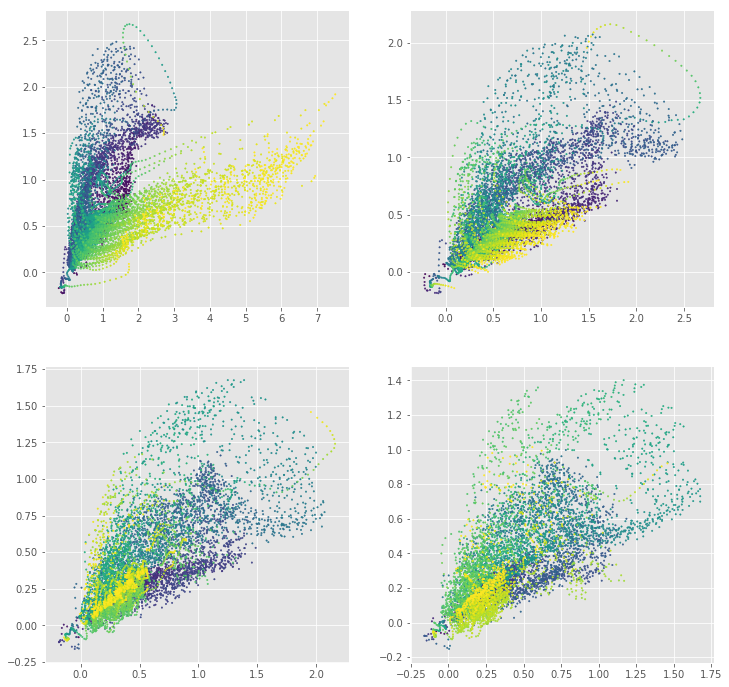

In [8]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(colors[:,i], colors[:,i+1], c=redshift, s=2)

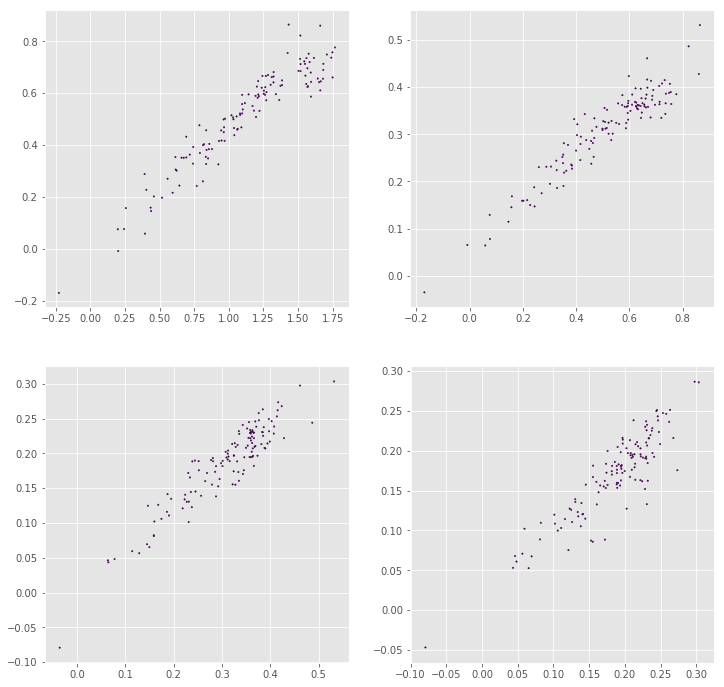

In [9]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(colors[:129,i], colors[:129,i+1], c=redshift[:129], s=2)

In [10]:
sim_cat_df = pd.DataFrame()
sim_cat_df['redshift'] = redshift
for i, band in list(enumerate(filters)):
    sim_cat_df['%s_mag' % band] = mags[:, i]

In [11]:
np.savetxt('../../Data_Augment/brown_template_train.csv', sim_cat_df.values)

In [12]:
sim_cat_df.to_csv('../data/brown_template_train.csv')

In [13]:
rest_frame_colors = colors[:129]

### Fit Gaussian Mixture Model to draw locations for ESP estimation

In [14]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test = train_test_split(rest_frame_colors, test_size = 0.3, random_state=1158)
for n_comp in range(1, 12):
    gmm = GaussianMixture(n_components=n_comp)
    gmm.fit(x_train)
    print(gmm.aic(x_test))

-525.4733324144081
-443.45661266374
-350.1697442033842
-310.3767943219062
-61.906352577400355
29.75276333206105
149.06224230225442
798.9489912444153
838.1953463487453
722.7453826654448
1734.847712321677


In [16]:
gmm = GaussianMixture(n_components=1, random_state=8511).fit(rest_frame_colors)

In [91]:
x_predict = gmm.sample(n_samples=1000)#2500)

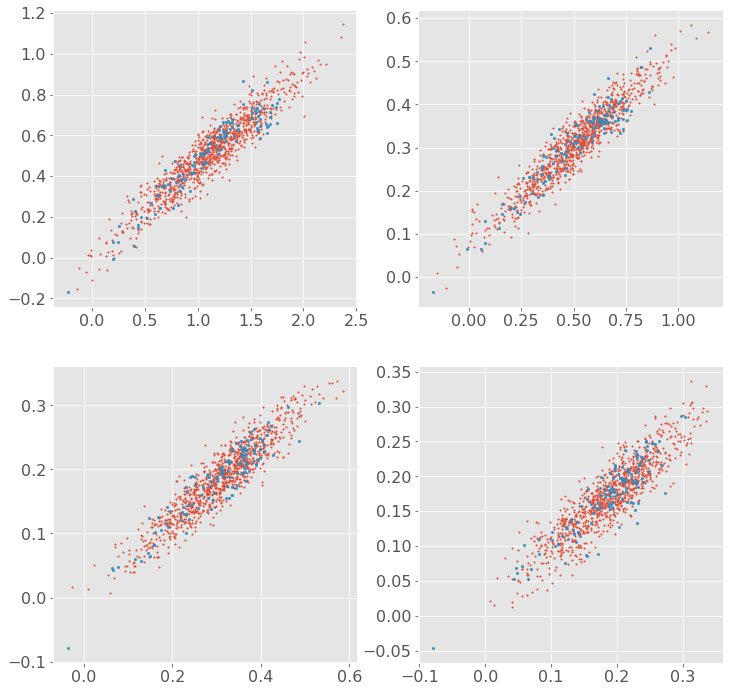

In [92]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(x_predict[0][:,i], x_predict[0][:,i+1], s=2)
    plt.scatter(rest_frame_colors[:,i], rest_frame_colors[:,i+1], s=6)

### Make denser training catalog

In [21]:
pca_obj.PCA(comps=10, minWavelen=49., maxWavelen=1200.)

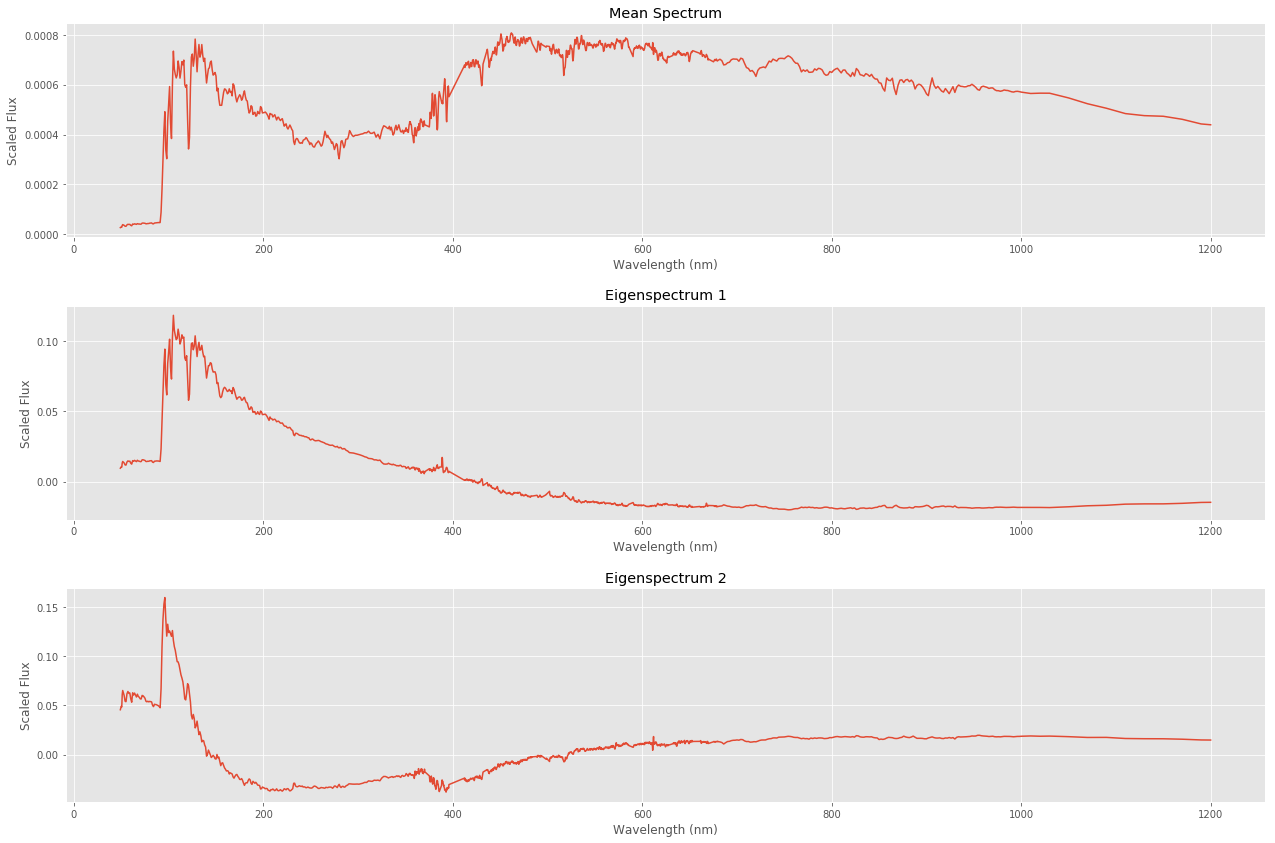

In [22]:
plotter = esp.plotUtils()
fig = plotter.plot_eigenspectra(pca_obj, 2)

In [23]:
np.sum(pca_obj.exp_var)

0.9919810146292223

In [25]:
import os
os.mkdir('brown_esp_results')
pca_obj.write_output('brown_esp_results')

In [93]:
gp_obj = esp.gaussianProcessEstimate(pca_obj, bandpass_dict, x_predict[0])

In [94]:
gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3, n_dim=5)

In [95]:
gp_spec = gp_obj.gp_predict(gp_kernel, opt_bandpass_dict=bandpass_dict)

In [96]:
gp_colors = gp_spec.calc_colors(bandpass_dict, 10)

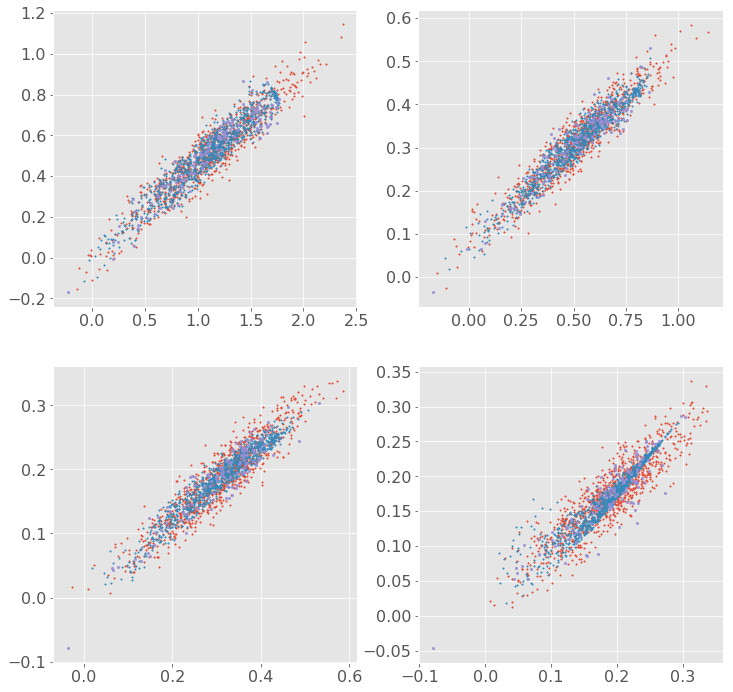

In [97]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(x_predict[0][:,i], x_predict[0][:,i+1], s=2)
    plt.scatter(gp_colors[:,i], gp_colors[:,i+1], s=2)
    plt.scatter(rest_frame_colors[:,i], rest_frame_colors[:,i+1], s=6)

In [98]:
#sq_exp_err = np.sqrt(np.mean(x_predict[0]**2. - gp_colors**2.))
#exp_err = np.sqrt(np.mean(x_predict[0]**2. - gp_colors**2.))
#m_52_err = np.sqrt(np.mean(x_predict[0]**2. - gp_colors**2.))
#m_32_err = np.sqrt(np.mean(x_predict[0]**2. - gp_colors**2.))

In [99]:
exp_err, sq_exp_err, m_32_err, m_52_err

NameError: name 'exp_err' is not defined

In [101]:
best_fit = np.where(np.max((x_predict[0]**2. - gp_colors**2.), axis=1) < 0.005)[0]
print(len(best_fit))

206


In [102]:
new_spec = gp_spec.reconstruct_spectra(10)[best_fit]

In [103]:
np.exp(gp_spec.params)

array([[2.41292462e-04, 7.91638965e+02],
       [6.41762055e-05, 6.36028446e+02],
       [5.01207298e-06, 1.43936779e+01],
       [2.44409114e-06, 8.18493620e+01],
       [4.84954713e-08, 1.00302774e-03],
       [2.07869054e-07, 2.63528224e-01],
       [9.16411130e-07, 2.66587672e+01],
       [3.48018172e-08, 1.84418080e-02],
       [3.20049087e-08, 2.05954215e-02],
       [1.51744011e-08, 1.66520478e-03]])

In [104]:
colors = []
mags = []
spec_val = []
redshift = []
for z_shift in np.arange(0., 3.51, 0.05):
    i = 0
    for sed_obj in new_spec:
        test_sed = Sed()
        test_sed.setSED(wavelen=pca_obj.wavelengths, flambda=sed_obj)
        test_sed.redshiftSED(z_shift)
        sed_mags = bandpass_dict.magListForSed(test_sed)
        if np.isinf(sed_mags).any():
            #print('drop')
            continue
        mags.append(sed_mags)
        colors.append(sed_mags[:-1] - sed_mags[1:])
        spec_val.append(i)
        redshift.append(z_shift)
        i+=1
colors = np.array(colors)
mags = np.array(mags)

/home/brycek/miniconda3/lib/python3.6/site-packages/esp/lsst_utils/Sed.py:1399: RuntimeWarning: divide by zero encountered in log10
  mags = -2.5*numpy.log10(fluxes) - self.zp


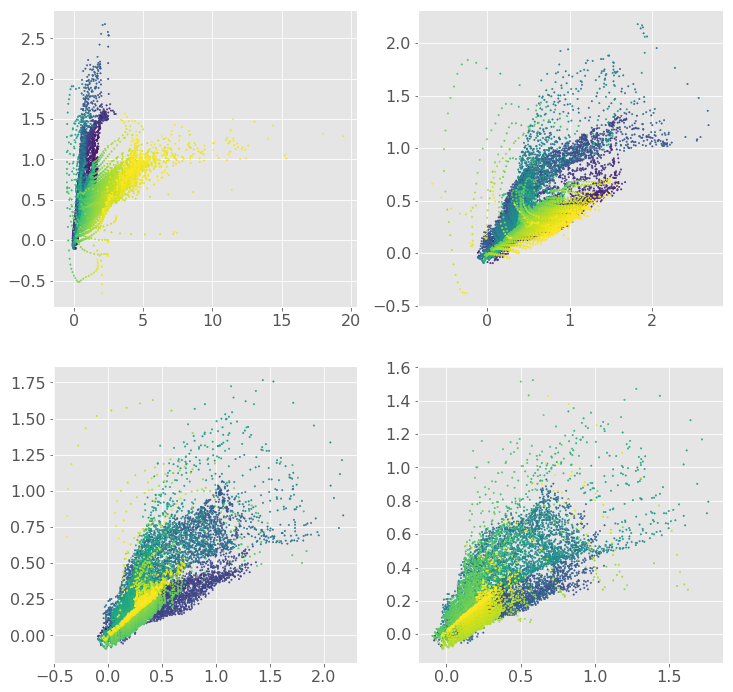

In [105]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(colors[:,i], colors[:,i+1], c=redshift, s=2)

In [106]:
len(redshift), len(mags)

(14599, 14599)

In [107]:
sim_cat_df = pd.DataFrame()
sim_cat_df['redshift'] = redshift
for i, band in list(enumerate(filters)):
    sim_cat_df['%s_mag' % band] = mags[:, i]

In [108]:
np.savetxt('../../Data_Augment/brown_esp_template_only_train.csv', sim_cat_df.values)

#### Make combined catalog

In [109]:
sim_cat_brown = np.genfromtxt('../../Data_Augment/brown_template_train.csv')
sim_cat_esp = np.genfromtxt('../../Data_Augment/brown_esp_template_only_train.csv')

In [110]:
sim_cat = np.concatenate((sim_cat_brown, sim_cat_esp))

In [111]:
len(sim_cat), len(sim_cat_esp), len(sim_cat_brown)

(23758, 14599, 9159)

In [112]:
np.savetxt('../../Data_Augment/brown_esp_template_added_train.csv', sim_cat)

### Load in original training set and use missing color points as interpolation points

In [52]:
#color_labels = np.genfromtxt('../data/train_labels_4_group_color_cut_0.dat'
color_gap_train_set = pd.read_csv('../data/train_cat_4_group_color_cut_0.dat')
full_test_set = pd.read_csv('../data/test_cat_full.dat')

In [53]:
from sklearn.neighbors import NearestNeighbors

In [54]:
color_gap_train_set.head()

,redshift,u,g,r,i,z,y
0,0.708277,27.5278,27.4826,27.0514,26.4112,26.3398,26.3135
1,3.297912,31.7478,26.6329,25.4428,25.3954,25.7079,25.7969
2,2.175147,26.4805,26.1697,26.2675,26.3462,26.2657,26.2155
3,2.100762,30.7369,28.4791,27.5407,27.2548,26.6204,26.2846
4,2.097417,26.6531,26.4531,26.5904,26.6739,26.6440,26.6244


In [55]:
for i in range(5):
    color_gap_train_set['%s-%s' % (filters[i], filters[i+1])] = \
        color_gap_train_set[filters[i]]-color_gap_train_set[filters[i+1]]

In [56]:
for i in range(5):
    full_test_set['%s-%s' % (filters[i], filters[i+1])] = \
        full_test_set[filters[i]]-full_test_set[filters[i+1]]

In [57]:
nbrs = NearestNeighbors(n_neighbors=1).fit(color_gap_train_set[['u-g', 'g-r', 'r-i', 'i-z', 'z-y']].values)

In [58]:
distances, indices = nbrs.kneighbors(full_test_set[['u-g', 'g-r', 'r-i', 'i-z', 'z-y']].values)

In [59]:
distances[:10], indices[:10]

(array([[0.00598999],
        [0.0206797 ],
        [0.0031225 ],
        [0.01038075],
        [0.00910659],
        [0.00736953],
        [0.00603075],
        [0.0060291 ],
        [0.00131529],
        [0.0042332 ]]), array([[240215],
        [347991],
        [ 86328],
        [332757],
        [ 56164],
        [397248],
        [192730],
        [295365],
        [378550],
        [ 55299]]))

In [60]:
missing_training = np.where(distances > 0.25)[0]
print(len(missing_training))

301944


In [61]:
missing_training = full_test_set.iloc[missing_training].reset_index(drop=True)
#for i in range(5):
#    missing_training['%s-%s' % (filters[i], filters[i+1])] = \
#        missing_training[filters[i]]-missing_training[filters[i+1]]

In [62]:
nbrs_2 = NearestNeighbors(n_neighbors=1).fit(missing_training[['u-g', 'g-r', 'r-i', 'i-z', 'z-y']].values)

In [113]:
sim_cat_df = pd.DataFrame(sim_cat, columns=['redshift', 'u', 'g', 'r', 'i', 'z', 'y'])
for i in range(5):
    sim_cat_df['%s-%s' % (filters[i], filters[i+1])] = \
       sim_cat_df[filters[i]]-sim_cat_df[filters[i+1]]

In [114]:
d2, i2 = nbrs_2.kneighbors(sim_cat_df[['u-g', 'g-r', 'r-i', 'i-z', 'z-y']].values)

In [115]:
target_area = np.where(d2 < 0.1)[0]

In [116]:
sim_target = sim_cat_df.iloc[target_area]

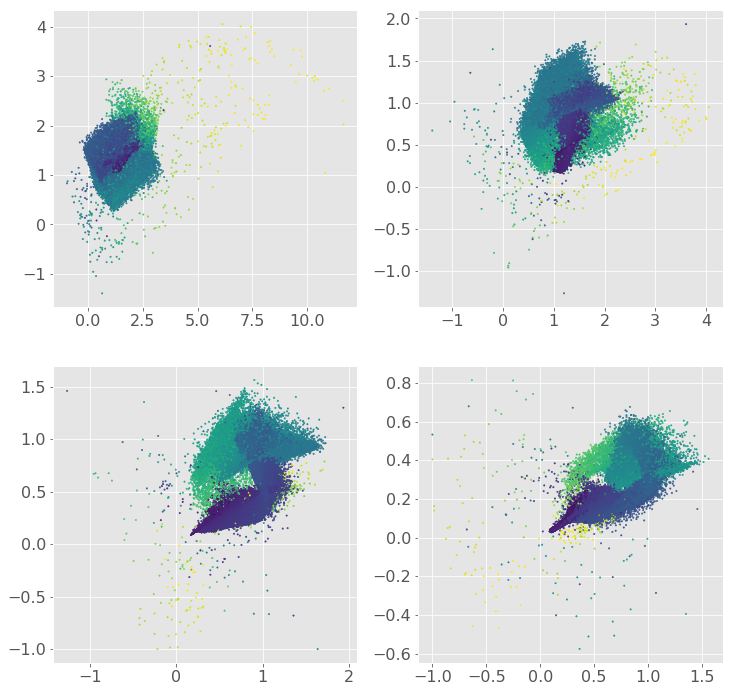

In [120]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(missing_training['%s-%s' % (filters[i], filters[i+1])],
                missing_training['%s-%s' % (filters[i+1], filters[i+2])],
                c=missing_training['redshift'], s=2)

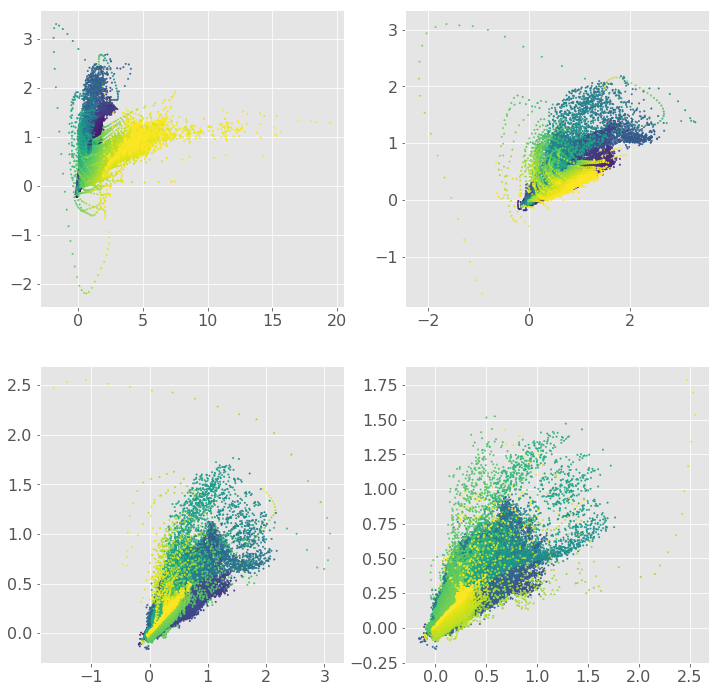

In [67]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(sim_cat_df['%s-%s' % (filters[i], filters[i+1])],
                sim_cat_df['%s-%s' % (filters[i+1], filters[i+2])],
                c=sim_cat_df['redshift'], s=2)

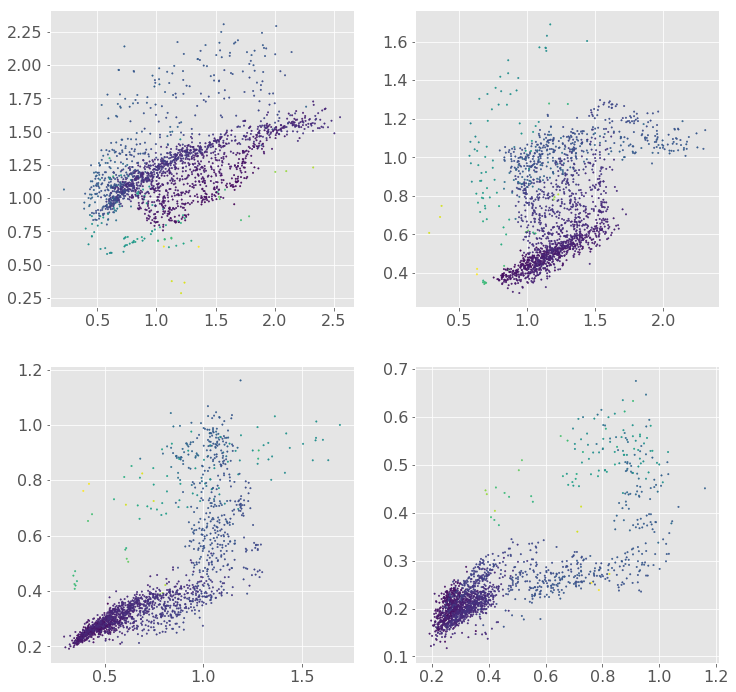

In [117]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(sim_target['%s-%s' % (filters[i], filters[i+1])],
                sim_target['%s-%s' % (filters[i+1], filters[i+2])],
                c=sim_target['redshift'], s=2)

In [118]:
sim_target = sim_target.reset_index(drop=True)

In [76]:
sim_target[['redshift', 'u', 'g', 'r', 'i', 'z', 'y']].to_csv('brown_esp_target_train.csv')

In [119]:
combined_cat = np.concatenate((color_gap_train_set, sim_target))

In [120]:
combined_df = pd.DataFrame(combined_cat[:, :7], columns=['redshift', 'u', 'g', 'r', 'i', 'z', 'y'])

In [121]:
combined_df.to_csv('train_cat_combined_esp_target.dat')

In [122]:
! scp *.dat brycek@epyc.astro.washington.edu:epyc/users/brycek/pam/data/

train_cat_combined_esp_target.dat             100%   27MB  13.4MB/s   00:02    
